###  This notebook comprises of a series of visuals I created for an arsenal specific transfer and squad analysis twitter thread for the 23/24 season. 
###  Data has been scraped from FBREF, notebook includes scraping logic and functions. 
 ####  - Visuals include: 
 #####          FBREF Stat Pizza Plots
 #####          FBREF Comparison Pizzas
 #####          FBREF Beeswarms
 #####          Rolling 22/23 Performnce Stats          

In [1]:
import requests
import json
from mobfot import MobFot

# %matplotlib inline


import unicodedata
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.image as image
import matplotlib.style as style
import matplotlib as mpl
import matplotlib.patheffects as pe
import warnings
import os
import numpy as np
from math import pi
from bs4 import BeautifulSoup
from urllib.request import urlopen
from highlight_text import fig_text
from adjustText import adjust_text
from soccerplots.radar_chart import Radar
from mplsoccer import PyPizza, add_image, FontManager

style.use('fivethirtyeight')


/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def fuzzy_merge(df_1, df_2, key1, key2, threshold=97, limit=1):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()
    
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    
    return df_1
    
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    only_ascii = str(only_ascii)
    only_ascii = only_ascii[2:-1]
    only_ascii = only_ascii.replace('-', ' ')
    return only_ascii


def years_converter(variable_value):
    if len(variable_value) > 3:
        years = variable_value[:-4]
        days = variable_value[3:]
        years_value = pd.to_numeric(years)
        days_value = pd.to_numeric(days)
        day_conv = days_value/365
        final_val = years_value + day_conv
    else:
        final_val = pd.to_numeric(variable_value)

    return final_val



In [3]:
def get_team_urls(x):  
    url = x
    data  = requests.get(url).text
    soup = BeautifulSoup(data)
    player_urls = []
    links = BeautifulSoup(data).select('th a')
    urls = [link['href'] for link in links]
    urls = list(set(urls))
    full_urls = []
    for y in urls:
        full_url = "https://fbref.com"+y
        full_urls.append(full_url)
    team_names = []
    for team in urls: 
        team_name_slice = team[20:-6]
        team_names.append(team_name_slice)
    list_of_tuples = list(zip(team_names, full_urls))
    Team_url_database = pd.DataFrame(list_of_tuples, columns = ['team_names', 'urls'])
    return Team_url_database


In [4]:
team_urls = get_team_urls("https://fbref.com/en/comps/9/Premier-League-Stats")  
full_urls = list(team_urls.urls.unique())

In [5]:
import time 

keepers = ['GK']
defenders = ["DF",'DF,MF']
wing_backs = ['FW,DF','DF,FW']
defensive_mids = ['MF,DF']
midfielders = ['MF']
attacking_mids = ['MF,FW',"FW,MF"]
forwards = ['FW']
def position_grouping(x):
    if x in keepers:
        return "GK"
    elif x in defenders:
        return "Defender"
    elif x in wing_backs:
        return "Wing-Back"
    elif x in defensive_mids:
        return "Defensive-Midfielders"
    elif x in midfielders:
        return "Central Midfielders"
    elif x in attacking_mids:
        return "Attacking Midfielders"
    elif x in forwards:
        return "Forwards"
    else:
        return "unidentified position"

def general_url_database(full_urls):    
    appended_data = []
    for team_url in full_urls:
        # url = team_url
        print(team_url)
        player_db = pd.DataFrame()
        player_urls = []
        # data  = requests.get(team_url).text
        links = BeautifulSoup(requests.get(team_url).text).select('th a')
        urls = [link['href'] for link in links]
        player_urls.append(urls)
        player_urls  = [item for sublist in player_urls  for item in sublist]
        player_urls.sort()
        player_urls = list(set(player_urls))
        p_url = list(filter(lambda k: 'players' in k, player_urls))
        url_final = []
        for y in p_url:
            full_url = "https://fbref.com"+y
            url_final.append(full_url)
        player_names = []
        for player in p_url: 
            player_name_slice = player[21:]
            player_name_slice = player_name_slice.replace('-', ' ')
            player_names.append(player_name_slice)
        # player_names
        list_of_tuples = list(zip(player_names, url_final))
        play_url_database = pd.DataFrame(list_of_tuples, columns = ['Player', 'urls'])
        player_db = pd.concat([play_url_database])

        # # html = requests.get(url).text
        # data2 = BeautifulSoup(requests.get(url).text, 'html5')
        table = BeautifulSoup(requests.get(team_url).text, 'html5').find('table')
        cols = []

        for header in table.find_all('th'):
            cols.append(header.string)

        cols = [i for i in cols if i is not None]

        columns = cols[6:39] #gets necessary column headers
        players = cols[39:-2]

        rows = [] #initliaze list to store all rows of data
        for rownum, row in enumerate(table.find_all('tr')): #find all rows in table
            if len(row.find_all('td')) > 0: 
                rowdata = [] #initiliaze list of row data
                for i in range(0,len(row.find_all('td'))): #get all column values for row
                    rowdata.append(row.find_all('td')[i].text)
                rows.append(rowdata)
        df = pd.DataFrame(rows, columns=columns)

        df.drop(df.tail(2).index,inplace=True)
        df["Player"] = players
        df = df[["Player","Pos","Age", "Starts"]]

        df['Player'] = df.apply(lambda x: remove_accents(x['Player']), axis=1)
        test_merge = fuzzy_merge(df, player_db, 'Player', 'Player', threshold=90)
        test_merge = test_merge.rename(columns={'matches': 'Player', 'Player': 'matches'})
        # test_merge = test_merge.drop(columns=['matches'])
        final_merge = test_merge.merge(player_db, on='Player', how='left')
        del df, table
        time.sleep(10)
        # list_of_dfs.append(final_merge)
        appended_data.append(final_merge)
    appended_data = pd.concat(appended_data)
    return appended_data 
def get_360_scouting_report(url):    
    start = url[0:38]+ "scout/365_m1/"
    def remove_first_n_char(org_str, n):
        mod_string = ""
        for i in range(n, len(org_str)):
            mod_string = mod_string + org_str[i]
        return mod_string
    mod_string = remove_first_n_char(url, 38)
    final_string = start+mod_string+"-Scouting-Report"    
    return final_string
    
def get_match_logs(url):    
    start = url[0:38]+ "matchlogs/2022-2023/summary/"
    def remove_first_n_char(org_str, n):
        mod_string = ""
        for i in range(n, len(org_str)):
            mod_string = mod_string + org_str[i]
        return mod_string
    mod_string = remove_first_n_char(url, 38)
    final_string = start+mod_string+"-Match-Logs"   
    return final_string

def create_EPL_play_db(full_urls):
    df = general_url_database(full_urls)
    df['Age'] = df.apply(lambda x: years_converter(x['Age']), axis=1)
    df = df.drop(columns=['matches'])
    df['scouting_url'] = df.apply(lambda x: get_360_scouting_report(x['urls']), axis=1)
    df['match_logs'] = df.apply(lambda x: get_match_logs(x['urls']), axis=1)
    df["position_group"] = df.Pos.apply(lambda x: position_grouping(x))
    df.reset_index(drop=True)
    df[["Starts"]] = df[["Starts"]].apply(pd.to_numeric)  
    return df

Function to create big Top 5 European leages Database 


In [6]:
from tqdm import tqdm
def generate_big_database(top_5_league_stats_urls):
    list_of_dfs = []   
    for url in tqdm(top_5_league_stats_urls):
        team_urls = get_team_urls(url)  
        full_urls = list(team_urls.urls.unique())
        Player_db = general_url_database(full_urls)
        Player_db['Age'] = Player_db.apply(lambda x: years_converter(x['Age']), axis=1)
        Player_db = Player_db.drop(columns=['matches'])
        Player_db = Player_db.dropna()
        Player_db['scouting_url'] = Player_db.apply(lambda x: get_360_scouting_report(x['urls']), axis=1)
        Player_db['match_logs'] = Player_db.apply(lambda x: get_match_logs(x['urls']), axis=1)
        Player_db["position_group"] = Player_db.Pos.apply(lambda x: position_grouping(x))
        Player_db.reset_index(drop=True)
        Player_db[["Starts"]] = Player_db[["Starts"]].apply(pd.to_numeric) 
        list_of_dfs.append(Player_db)
    dfs = pd.concat(list_of_dfs)
    return dfs

Load list of link for top 5 leagues url to be looped through in subsequent function

In [7]:
top_6_league_stats_urls = ['https://fbref.com/en/comps/9/Premier-League-Stats']
                            # 'https://fbref.com/en/comps/11/Serie-A-Stats', 'https://fbref.com/en/comps/13/Ligue-1-Stats', 'https://fbref.com/en/comps/12/La-Liga-Stats', 'https://fbref.com/en/comps/20/Bundesliga-Stats',"https://fbref.com/en/comps/23/Eredivisie-Stats" ]


In [8]:
# EU_TOP_5_DB = generate_big_database(top_6_league_stats_urls)


Add in Eredivise as well

In [9]:
# EU_TOP_5_DB = pd.concat([EU_TOP_5_DB, ERERDIVISE])
EU_TOP_5_DB.to_csv('CSVs/EU_TOP_5L_Database.csv')

NameError: name 'EU_TOP_5_DB' is not defined

In [10]:
EU_TOP_5_DB = pd.read_csv('CSVs/EU_TOP_5L_Database.csv')

In [11]:
# df = EU_TOP_5_DB[EU_TOP_5_DB.Player.isin(["Serge Gnabry"])]

Store fonts for charts

In [12]:
font_normal = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Regular.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Italic.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab[wght].ttf')

Function to create/pull advanced data from FBREF

In [14]:
def generate_advanced_data(scout_links):
    appended_data_per90 = []
    appended_data_percent = []
    for x in scout_links:
        warnings.filterwarnings("ignore")
        url = x
        page =requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        name = [element.text for element in soup.find_all("span")]
        name = name[7]
        html_content = requests.get(url).text
        df = pd.read_html(html_content)
        df[-1].columns = df[-1].columns.droplevel(0) # drop top header row
        stats = df[-1]
        # stats = df[0]
        advanced_stats = stats.loc[(stats['Statistic'] != "Statistic" ) & (stats['Statistic'] != ' ')]
        advanced_stats = advanced_stats.dropna(subset=['Statistic',"Per 90", "Percentile"])
        per_90_df = advanced_stats[['Statistic',"Per 90",]].set_index("Statistic").T
        per_90_df["Name"] = name
        percentile_df = advanced_stats[['Statistic',"Percentile",]].set_index("Statistic").T
        percentile_df["Name"] = name
        appended_data_per90.append(per_90_df)
        appended_data_percent.append(percentile_df)
        del df, soup
        time.sleep(10)
        print(name)
    appended_data_per90 = pd.concat(appended_data_per90)
    appended_data_per90 = appended_data_per90.reset_index(drop=True)
    appended_data_per90 = appended_data_per90[['Name'] + [col for col in appended_data_per90.columns if col != 'Name']]
    appended_data_per90 = appended_data_per90.loc[:,~appended_data_per90.columns.duplicated()]
    appended_data_percentile = pd.concat(appended_data_percent)
    appended_data_percentile = appended_data_percentile.reset_index(drop=True)
    # del appended_data_percentile.columns.name
    appended_data_percentile = appended_data_percentile[['Name'] + [col for col in appended_data_percentile.columns if col != 'Name']]
    appended_data_percentile = appended_data_percentile.loc[:,~appended_data_percentile.columns.duplicated()]
    list_of_dfs = [appended_data_per90,appended_data_percentile]
    return list_of_dfs

Create lists for pulling out specific stats 

In [15]:
attacking = ["Name",'Goals', 'Assists', 'Non-Penalty Goals','Penalty Kicks Attempted', 'xG',
      'xA', 'npxG+xA', 'Shots Total', 'Shots on target', 'npxG/Sh',
       'Goals - xG', 'Non-Penalty Goals - npxG']
passing = ["Name", 'Passes Completed','Passes Attempted', 'Total Passing Distance',
       'Progressive Passing Distance', 
       'Key Passes', 'Passes into Final Third',
       'Passes into Penalty Area', 'Crosses into Penalty Area',
       'Progressive Passes']
pass_length = ['Passes Completed (Short)',
       'Passes Attempted (Short)', 'Pass Completion % (Short)',
       'Passes Completed (Medium)', 'Passes Attempted (Medium)',
       'Pass Completion % (Medium)', 'Passes Completed (Long)',
       'Passes Attempted (Long)', 'Pass Completion % (Long)']       
pass_types = ["Name", 'Live-ball passes', 'Dead-ball passes',
       'Passes from Free Kicks', 'Through Balls', 'Passes Under Pressure',
       'Switches', 'Crosses', 'Corner Kicks', 'Inswinging Corner Kicks',
       'Outswinging Corner Kicks', 'Straight Corner Kicks',
       'Ground passes', 'Low Passes', 'High Passes',
       'Passes Attempted (Left)', 'Passes Attempted (Right)',
       'Passes Attempted (Head)', 'Throw-Ins taken',
       'Passes Attempted (Other)', 'Passes Offside',
       'Passes Out of Bounds', 'Passes Intercepted', 'Passes Blocked']
chance_creation = ["Name",'Shot-Creating Actions', 'SCA (PassLive)', 'SCA (PassDead)',
       'SCA (Drib)', 'SCA (Sh)', 'SCA (Fld)', 'SCA (Def)',
       'Goal-Creating Actions', 'GCA (PassLive)', 'GCA (PassDead)',
       'GCA (Drib)', 'GCA (Sh)', 'GCA (Fld)', 'GCA (Def)']
defending = [ "Name", 'Tackles',
       'Tackles Won',  'Dribblers Tackled', 'Dribbled Past', 'Pressures',
       'Successful Pressures',
       'Blocks', 'Shots Blocked', 'Shots Saved',
       'Interceptions', 'Tkl+Int', 'Clearances', 'Errors','Ball Recoveries',
       'Aerials won', 'Aerials lost']
possesion = ["Name", 'Touches',
       'Dribbles Completed', 'Dribbles Attempted',
       'Players Dribbled Past',
       'Total Carrying Distance', 'Progressive Carrying Distance',
       'Progressive Carries', 'Carries into Final Third', 'Miscontrols', 'Dispossessed',
       'Passes Received',
       'Progressive Passes Rec']
dicipline = ["Name", 'Yellow Cards', 'Red Cards','Second Yellow Card', 'Fouls Committed','Offsides','Penalty Kicks Conceded', 'Own Goals']
smarts = ["Name",'Penalty Kicks Won','Fouls Drawn']


Create Single Genral Pizza Plot

In [24]:
def create_single_Pizza(player_name): 
    # parameter list
    params = [
        "Non-Penalty Goals", "npxG + xAG", "Assists",
        "Shot-Creating Actions", "Carries into Penalty Area",
        "Touches", "Progressive Passes", "Progressive Carries",
        "Passes into Penalty Area", "Crosses",
        "Interceptions", "Tackles Won",
        "Passes Blocked", "Ball Recoveries", "Aerials Won"
    ]

    subset_of_data = EU_TOP_5_DB.query('Player == @player_name' )
    scout_links = list(subset_of_data.scouting_url.unique())
    appended_data_percentile = generate_advanced_data(scout_links)[1]
    appended_data_percentile = appended_data_percentile[params]
    cols = appended_data_percentile.columns
    appended_data_percentile[cols] = appended_data_percentile[cols].apply(pd.to_numeric)
    params = list(appended_data_percentile.columns)
    # params = params[1:]


    values = appended_data_percentile.iloc[0].values.tolist()
    # values = values[1:]

    get_clubs = subset_of_data[subset_of_data.Player.isin([player_name])]
    link_list = list(get_clubs.urls.unique())
    title_vars = []
    for x in link_list:     
        warnings.filterwarnings("ignore")
        html_content = requests.get(x).text
        df2 = pd.read_html(html_content)
        df2[5].columns = df2[5].columns.droplevel(0) 
        stats2 = df2[5]
        key_vars = stats2[["Season","Age","Squad"]]
        key_vars = key_vars[key_vars.Season.isin(["2021-2022"])]
        title_vars.append(key_vars)
    title_vars = pd.concat(title_vars)
    teams = list(title_vars.Squad.unique())[0]


    style.use('fivethirtyeight')


    # color for the slices and text
    slice_colors = ["#1A78CF"] * 5 + ["#FF9300"] * 5 + ["#D70232"] * 5
    text_colors = ["#000000"] * 10 + ["#F2F2F2"] * 5

    # instantiate PyPizza class
    baker = PyPizza(
        params=params,                  # list of parameters
        background_color="#EBEBE9",     # background color
        straight_line_color="#EBEBE9",  # color for straight lines
        straight_line_lw=1,             # linewidth for straight lines
        last_circle_lw=0,               # linewidth of last circle
        other_circle_lw=0,              # linewidth for other circles
        inner_circle_size=20            # size of inner circle
    )

    # plot pizza
    fig, ax = baker.make_pizza(
        values,                          # list of values
        figsize=(8, 8.5),                # adjust figsize according to your need
        color_blank_space="same",        # use same color to fill blank space
        slice_colors=slice_colors,       # color for individual slices
        value_colors=text_colors,        # color for the value-text
        value_bck_colors=slice_colors,   # color for the blank spaces
        blank_alpha=0.4,                 # alpha for blank-space colors
        kwargs_slices=dict(
            edgecolor="#F2F2F2", zorder=2, linewidth=1
        ),                               # values to be used when plotting slices
        kwargs_params=dict(
            color="#000000", fontsize=9,
            fontproperties=font_normal.prop, va="center"
        ),                               # values to be used when adding parameter
        kwargs_values=dict(
            color="#000000", fontsize=11,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", facecolor="cornflowerblue",
                boxstyle="round,pad=0.2", lw=1
            )
        )                                # values to be used when adding parameter-values
    )

    # add title
    fig.text(
        0.05, 0.985, f"{player_name} - {teams}", size=14,
        ha="left", fontproperties=font_bold.prop, color="#000000"
    )

    # add subtitle
    fig.text(
        0.05, 0.963,
        f"Percentile Rank vs Top-Five League {subset_of_data.position_group.unique()[0]} | Season 2023-24",
        size=10,
        ha="left", fontproperties=font_bold.prop, color="#000000"
    )

    # add credits
    CREDIT_1 = "@stephenaq7\ndata via FBREF / Opta"
    CREDIT_2 = "inspired by: @Worville, @FootballSlices"

    fig.text(
        0.99, 0.005, f"{CREDIT_1}\n{CREDIT_2}", size=9,
        fontproperties=font_italic.prop, color="#000000",
        ha="right"
    )

    # add text
    fig.text(
        0.08, 0.925, "Attacking          Possession        Defending", size=12,
        fontproperties=font_bold.prop, color="#000000"
    )

    # add rectangles
    fig.patches.extend([
        plt.Rectangle(
            (0.05, 0.9225), 0.025, 0.021, fill=True, color="#1a78cf",
            transform=fig.transFigure, figure=fig
        ),
        plt.Rectangle(
            (0.2, 0.9225), 0.025, 0.021, fill=True, color="#ff9300",
            transform=fig.transFigure, figure=fig
        ),
        plt.Rectangle(
            (0.351, 0.9225), 0.025, 0.021, fill=True, color="#d70232",
            transform=fig.transFigure, figure=fig
        ),
    ])

    # add image
    ### Add Stats by Steve logo
    ax3 = fig.add_axes([0.80, 0.075, 0.15, 1.75])
    ax3.axis('off')
    img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/outputs/piqmain.png')
    ax3.imshow(img)
    plt.savefig(
	f"Twitter_img/{player_name} - plot.png",
	dpi = 500,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)
    plt.show()

In [25]:
players = ['Jamal Musiala',
 'Cole Palmer',
 'Rafael Leao',
 'Raphinha',
 'Amine Adli',
 'Brahim DIaz',
 'Nico Williams',
 'Edon Zhegrova',
 'Michael Olise',
 'Phil Foden',
 'Alex Baena',
 'Leon Bailey',
 'Lamine Yamal',
 'Jeremy Doku',
 'Chris Führich',
 'Ademola Lookman',
 'Pedro Neto',
 'Eberechi Eze',
 'Bradley Barcola',
 'Luis Sinisterra']

In [26]:
players = ['Leon Bailey']

Leon Bailey


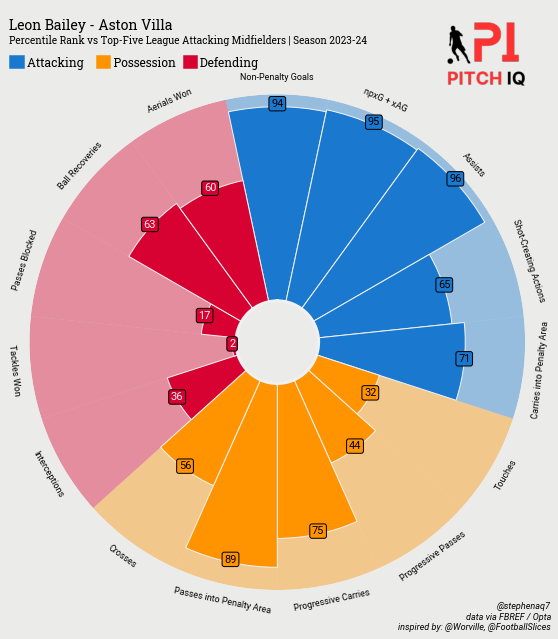

In [27]:
for player in players:
    create_single_Pizza(player)
    

Create comparison pizza chart 

In [113]:
def create_comparison_pizza(player1_name, player2_name):  

    params = [
        "Non-Penalty Goals", "npxG + xAG", "Assists",
        "Shot-Creating Actions", "Carries into Penalty Area",
        "Touches", "Progressive Passes", "Progressive Carries",
        "Passes into Penalty Area", "Crosses",
        "Interceptions", "Tackles Won",
        "Passes Blocked", "Ball Recoveries", "Aerials won"
    ]
        
    def generate_values(player_name,params):
        subset_of_data = EU_TOP_5_DB.query('Player == @player_name')
        scout_links = list(subset_of_data.scouting_url.unique())
        appended_data_percentile = generate_advanced_data(scout_links)[0]
        appended_data_percentile = appended_data_percentile[params]
        cols = appended_data_percentile.columns
        appended_data_percentile[cols] = appended_data_percentile[cols].apply(pd.to_numeric)
        params = list(appended_data_percentile.columns)

        values = appended_data_percentile.iloc[0].values.tolist()

        get_clubs = subset_of_data[subset_of_data.Player.isin([player_name])]
        link_list = list(get_clubs.urls.unique())
        title_vars = []
        for x in link_list:
            warnings.filterwarnings("ignore")
            html_content = requests.get(x).text.replace('<!--', '').replace('-->', '')
            df2 = pd.read_html(html_content)
            df2[5].columns = df2[5].columns.droplevel(0)
            stats2 = df2[5]
            key_vars = stats2[["Season", "Age", "Squad"]]
            key_vars = key_vars[key_vars.Season.isin(["2021-2022"])]
            title_vars.append(key_vars)
        title_vars = pd.concat(title_vars)
        teams = list(title_vars.Squad.unique())[0]

        return values, teams



    values, teams_1 = generate_values(player1_name, params)
    values_2, teams_2 = generate_values(player2_name,params)


    style.use('fivethirtyeight')


    min_range = [min(value, value_2) * 0.5 for value, value_2 in zip(values, values_2)]
    max_range = [max(value, value_2) * 1.05 for value, value_2 in zip(values, values_2)]



    # pass True in that parameter-index whose values are to be adjusted
    # here True values are passed for "Pressure Regains", "pAdj Tackles" params
    params_offset = [True] * len(max_range)

    # instantiate PyPizza class
    baker = PyPizza(
        params=params,
        min_range=min_range,        # min range values
        max_range=max_range,        # max range values
        background_color="#222222", straight_line_color="#000000",
        last_circle_color="#000000", last_circle_lw=2.5, other_circle_lw=0,
        other_circle_color="#000000", straight_line_lw=1
    )

    # plot pizza
    fig, ax = baker.make_pizza(
        values,                     # list of values
        compare_values=values_2,    # passing comparison values
        figsize=(10, 10),             # adjust figsize according to your need
        color_blank_space="same",   # use same color to fill blank space
        blank_alpha=0.4,            # alpha for blank-space colors
        param_location=110,         # where the parameters will be added
        kwargs_slices=dict(
            facecolor="#1A78CF", edgecolor="#000000",
            zorder=1, linewidth=1
        ),                          # values to be used when plotting slices
        kwargs_compare=dict(
            facecolor="#ff9300", edgecolor="#222222", zorder=3, linewidth=1,
        ),                          # values to be used when plotting comparison slices
        kwargs_params=dict(
            color="#F2F2F2", fontsize=12, zorder=5,
            fontproperties=font_normal.prop, va="center"
        ),                          # values to be used when adding parameter
        kwargs_values=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", facecolor="#1A78CF",
                boxstyle="round,pad=0.2", lw=1
            )
        ),                           # values to be used when adding parameter-values
        kwargs_compare_values=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", facecolor="#FF9300",
                boxstyle="round,pad=0.2", lw=1
            )
        )                            # values to be used when adding comparison-values
    )


    # adjust the texts
    # to adjust text for comparison-values-text pass adj_comp_values=True
    baker.adjust_texts(params_offset, offset=-0.17)

    # add title
    fig_text(
        0.515, 0.99, f"<{player1_name}> vs <{player2_name}>",
        size=16, fig=fig,
        highlight_textprops=[{"color": '#1A78CF'}, {"color": '#FF9300'}],
        ha="center", fontproperties=font_bold.prop, color="#F2F2F2"
    )
    # add credits
    CREDIT_1 = "@stephenaq7\ndata via FBREF / Opta"
    CREDIT_2 = "inspired by: @Worville, @FootballSlices"

    fig.text(
        0.99, 0.005, f"{CREDIT_1}\n{CREDIT_2}", size=9,
        fontproperties=font_italic.prop, color="#F2F2F2",
        ha="right"
    )

    # add image
    ### Add Stats by Steve logo
    ax3 = fig.add_axes([0.80, 0.075, 0.15, 1.75])
    ax3.axis('off')
    img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/outputs/PITCH IQ PRIMARY.png')
    ax3.imshow(img)
    plt.savefig(
    f"Twitter_img/{player1_name}> vs <{player2_name} - plot.png",
    dpi = 500,
    facecolor = "#EFE9E6",
    bbox_inches="tight",
    edgecolor="none",
    transparent = False
    )

    plt.show()

Teun Koopmeiners
Granit Xhaka


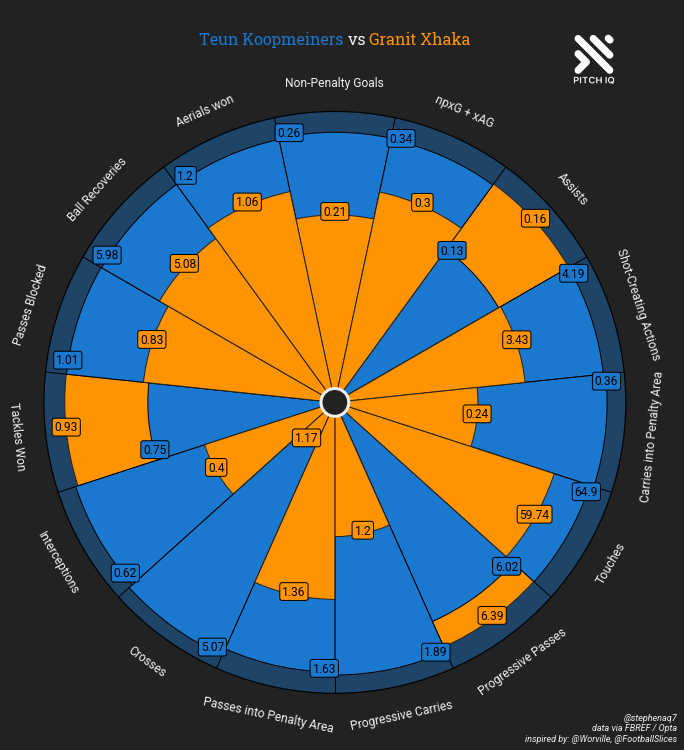

In [114]:
create_comparison_pizza('Teun Koopmeiners', 'Granit Xhaka')

In [ ]:
from mplsoccer import Radar, FontManager, grid
import matplotlib.pyplot as plt

# parameter names of the statistics we want to show
params = ["npxG", "Non-Penalty Goals", "xA", "Key Passes", "Through Balls",
          "Progressive Passes", "Shot-Creating Actions", "Goal-Creating Actions",
          "Dribbles Completed", "Pressure Regains", "Touches In Box", "Miscontrol"]

URL1 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-Regular.ttf')
serif_regular = FontManager(URL1)
URL2 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-ExtraLight.ttf')
serif_extra_light = FontManager(URL2)
URL3 = ('https://raw.githubusercontent.com/google/fonts/main/ofl/rubikmonoone/'
        'RubikMonoOne-Regular.ttf')
rubik_regular = FontManager(URL3)
URL4 = 'https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Thin.ttf'
robotto_thin = FontManager(URL4)
URL5 = ('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
        'RobotoSlab%5Bwght%5D.ttf')
robotto_bold = FontManager(URL5)

# The lower and upper boundaries for the statistics
low =  [0.08, 0.0, 0.1, 1, 0.6,  4, 3, 0.3, 0.3, 2.0, 2, 0]
high = [0.37, 0.6, 0.6, 4, 1.2, 10, 8, 1.3, 1.5, 5.5, 5, 5]

# Add anything to this list where having a lower number is better
# this flips the statistic
lower_is_better = ['Miscontrol']

radar = Radar(params, low, high,
              lower_is_better=lower_is_better,
              # whether to round any of the labels to integers instead of decimal places
              round_int=[False]*len(params),
              num_rings=4,  # the number of concentric circles (excluding center circle)
              # if the ring_width is more than the center_circle_radius then
              # the center circle radius will be wider than the width of the concentric circles
              ring_width=1, center_circle_radius=1)





# creating the figure using the grid function from mplsoccer:
fig, axs = grid(figheight=14, grid_height=0.915, title_height=0.06, endnote_height=0.025,
                title_space=0, endnote_space=0, grid_key='radar', axis=False)

# plot the radar
radar.setup_axis(ax=axs['radar'])
rings_inner = radar.draw_circles(ax=axs['radar'], facecolor='#ffb2b2', edgecolor='#fc5f5f')
radar_output = radar.draw_radar(bruno_values, ax=axs['radar'],
                                kwargs_radar={'facecolor': '#aa65b2'},
                                kwargs_rings={'facecolor': '#66d8ba'})
radar_poly, rings_outer, vertices = radar_output
range_labels = radar.draw_range_labels(ax=axs['radar'], fontsize=25,
                                       fontproperties=robotto_thin.prop)
param_labels = radar.draw_param_labels(ax=axs['radar'], fontsize=25,
                                       fontproperties=robotto_thin.prop)

# adding the endnote and title text (these axes range from 0-1, i.e. 0, 0 is the bottom left)
# Note we are slightly offsetting the text from the edges by 0.01 (1%, e.g. 0.99)
endnote_text = axs['endnote'].text(0.99, 0.5, 'Inspired By: StatsBomb / Rami Moghadam', fontsize=15,
                                   fontproperties=robotto_thin.prop, ha='right', va='center')
title1_text = axs['title'].text(0.01, 0.65, 'Bruno Fernandes', fontsize=25,
                                fontproperties=robotto_bold.prop, ha='left', va='center')
title2_text = axs['title'].text(0.01, 0.25, 'Manchester United', fontsize=20,
                                fontproperties=robotto_thin.prop,
                                ha='left', va='center', color='#B6282F')
title3_text = axs['title'].text(0.99, 0.65, 'Radar Chart', fontsize=25,
                                fontproperties=robotto_bold.prop, ha='right', va='center')
title4_text = axs['title'].text(0.99, 0.25, 'Midfielder', fontsize=20,
                                fontproperties=robotto_thin.prop,
                                ha='right', va='center', color='#B6282F')
                                       fontproperties=robotto_thin.prop)

Create Beeswarms-Plots

In [200]:
import seaborn as sns
import highlight_text


position = 'Attacking Midfielders'
pl_starts = 5
max_age = 35

params = [ "npxG + xAG", "Key Passes",
    "Shot-Creating Actions",  "Progressive Passes", "Progressive Carries","Shots on target"
]

subset_of_data = EU_TOP_5_DB.query('position_group == @position & Starts > @pl_starts & Age < @max_age' )
scout_links = list(subset_of_data.scouting_url.unique())
print(len(scout_links))
appended_data_per90= generate_advanced_data(scout_links)[0]
appended_data_per90 = appended_data_per90[['Name']+ params]
cols = appended_data_per90.columns
cols = cols[1:]
appended_data_per90[cols] = appended_data_per90[cols].apply(pd.to_numeric)

371
Harvey Elliott
Cody Gakpo
Roberto Firmino
Jack Harrison
Brenden Aaronson
Rodrigo
Degnand Gnonto
Leandro Trossard
Kai Havertz
Raheem Sterling
Mason Mount
João Félix
Mykhailo Mudryk
Hakim Ziyech
Harvey Barnes
James Maddison
Kelechi Iheanacho
Dennis Praet
Michael Olise
Jordan Ayew
Jeffrey Schlupp
Eberechi Eze
Wilfried Zaha
Bruno Fernandes
Jadon Sancho
Wout Weghorst
Philip Billing
Dominic Solanke
Ryan Christie
Marcus Tavernier
Dango Ouattara
Jaidon Anthony
Mohamed Elyounoussi
Stuart Armstrong
Adam Armstrong
Joe Aribo
Theo Walcott
Carlos Alcaraz
Kamaldeen Sulemana
Jacob Ramsey
John McGinn
Emi Buendía
Leon Bailey
Philippe Coutinho
Joelinton
Son Heung-min
Dejan Kulusevski
Richarlison
Alex Iwobi
Dwight McNeil
Demarai Gray
Daniel Podence
Pedro Neto
Adama Traoré
Hwang Hee-chan
Pablo Sarabia
Gonçalo Guedes
Jarrod Bowen
Saïd Benrahma
Pablo Fornals
Kaoru Mitoma
Julio César Enciso
Mikkel Damsgaard
Morgan Gibbs-White
Brennan Johnson
Jesse Lingard
Emmanuel Dennis
Bernardo Silva
Riyad Mahrez
Julián

ValueError: No tables found

In [ ]:
player_name = 'Kai Havertz'

Text(0.12, 0.01, '@stephenaq7 data via FBREF / Opta')

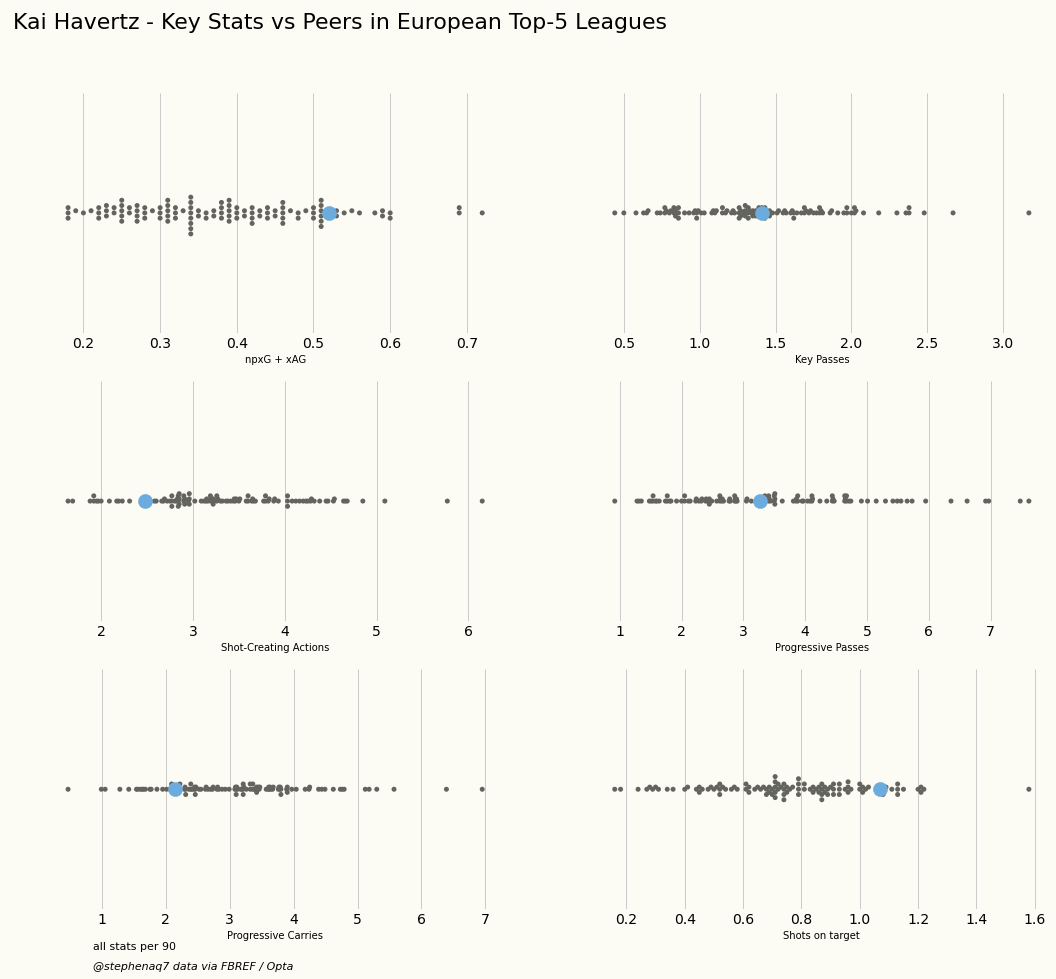

In [ ]:
text_color = 'black'
background = '#FCFBF4'

style.use('fivethirtyeight')


fig,axes = plt.subplots(3,2,figsize=(16,14))
fig.set_facecolor(background)
# ax.patch.set_facecolor(background)

#set up our base layer
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color

#create a list of comparisons
counter=0
counter2=0
met_counter = 0

for i,ax in zip(appended_data_per90['Name'],axes.flatten()):
    ax.set_facecolor(background)
    ax.grid(ls='dotted',lw=.5,color='lightgrey',axis='y',zorder=1)
    
    spines = ['top','bottom','left','right']
    for x in spines:
        if x in spines:
            ax.spines[x].set_visible(False)
            
    sns.swarmplot(x=params[met_counter],data=appended_data_per90,ax=axes[counter,counter2],zorder=1,color='#64645e')
    ax.set_xlabel(f'{params[met_counter]}',fontsize=10,c='black')
    
    for x in range(len(appended_data_per90['Name'])):

        if appended_data_per90['Name'][x] == player_name:
            ax.scatter(x=appended_data_per90[params[met_counter]][x],y=0,s=200,c='#6CABDD',zorder=2)
                        
    met_counter+=1
    if counter2 == 0:
        counter2 = 1
        continue
    if counter2 == 1:
        counter2 = 0
        counter+=1
        

        
s=f'<{player_name}> - Key Stats vs Peers in European Top-5 Leagues'
highlight_text.fig_text(s=s,
                x=.05, y=.95,
                #highlight_weights = ['bold'],
                fontsize=22,
                fontfamily = 'DM Sans',
                # highlight_colors = ['#6CABDD'],
                va='center'
               )

fig.text(.12,.03,"all stats per 90",fontsize=11, fontfamily='DM Sans',color=text_color)
fig.text(.12,.01,"@stephenaq7 data via FBREF / Opta", fontstyle='italic',fontsize=11, fontfamily='DM Sans',color=text_color)

# plt.savefig('test.png',dpi=500,bbox_inches = 'tight',facecolor=background)

In [ ]:
def generate_squadlist(url):
    html = requests.get(url).text
    data = BeautifulSoup(html, 'html5')
    table = data.find('table')
    cols = []

    for header in table.find_all('th'):
        cols.append(header.string)

    columns = cols[9:42] #gets necessary column headers
    players = cols[42:-2]

    #display(columns)
    rows = [] #initliaze list to store all rows of data
    for rownum, row in enumerate(table.find_all('tr')): #find all rows in table
        if len(row.find_all('td')) > 0: 
            rowdata = [] #initiliaze list of row data
            for i in range(0,len(row.find_all('td'))): #get all column values for row
                rowdata.append(row.find_all('td')[i].text)
            rows.append(rowdata)
    df = pd.DataFrame(rows, columns=columns)

    df.drop(df.tail(2).index,inplace=True)
    df["Player"] = players
    df.drop('Matches', axis=1, inplace=True)
    df['Nation'] = df['Nation'].str[3:]
    # df["team"] = name
    df.set_index("Player")

    return df 

In [ ]:
team = "https://fbref.com/en/squads/18bb7c10/Arsenal-Stats"
team_name = team[37:-6]
squad_stats_per_team = generate_squadlist(team)
squad_stats_per_team = squad_stats_per_team[squad_stats_per_team['90s'].notnull()]
squad_stats_per_team.head()

,Nation,Pos,Age,MP,Starts,Min,90s,Gls,Ast,G+A,...,Ast,G+A,G-PK,G+A-PK,xG,xAG,xG+xAG,npxG,npxG+xAG,Player
0,ENG,GK,25-013,37,37,"3,330",37.0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Aaron Ramsdale
1,BRA,DF,25-159,37,37,"3,319",36.9,3,0,3,...,0.00,0.08,0.08,0.08,0.14,0.01,0.14,0.14,0.14,Gabriel Dos Santos
2,ENG,FW,21-264,37,36,"3,122",34.7,13,11,24,...,0.32,0.69,0.32,0.63,0.32,0.24,0.55,0.25,0.49,Bukayo Saka
3,NOR,MF,24-161,36,36,"3,053",33.9,15,7,22,...,0.21,0.65,0.44,0.65,0.29,0.23,0.52,0.29,0.52,Martin Ødegaard
4,ENG,DF,25-231,37,35,"2,965",32.9,2,5,7,...,0.15,0.21,0.06,0.21,0.04,0.10,0.14,0.04,0.14,Ben White


In [ ]:
def years_converter(variable_value):
    years = variable_value[:-4]
    days = variable_value[3:]
    years_value = pd.to_numeric(years)
    days_value = pd.to_numeric(days)
    day_conv = days_value/365
    final_val = years_value + day_conv

    return final_val
squad_stats_per_team['Age'] = squad_stats_per_team.apply(lambda x: years_converter(x['Age']), axis=1)

In [ ]:
from urllib.request import urlopen
from PIL import Image
import urllib
def squad_age_profile_chart(df, team_name):
        df[["Age","90s"]] = df[["Age","90s"]].apply(pd.to_numeric)
        df = df.dropna(subset=["90s"])
        df["Min_pct"] = 100*df["90s"]/37##number of matches in a Serie A season
        df = df[df['Min_pct'] >0.5]
        df = df.dropna(subset=["Min_pct"])
        df = df.loc[:len(df)-1, :]
        df[["Player", "Pos", "Age", "Min_pct"]].head()

        line_color = "silver"
        marker_color = "dodgerblue"
        fig, ax = plt.subplots(figsize=(12, 8)) 

        # plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
        style.use('fivethirtyeight')
        ax.scatter(df["Age"], df["Min_pct"],alpha=0.8) ##scatter points
        ax.fill([24, 29, 29, 24], [-6, -6, 106, 106], color='limegreen',
                alpha=0.3, zorder=2) ##the peak age shaded region
        ax.text(26.5, 55, "PEAK", color=line_color, zorder=3, 
                alpha=1, fontsize=26, rotation=90, ha='center',
                va='center', fontweight='bold') ## `PEAK` age text
        texts = [] ##plot player names
        for row in df.itertuples():
                texts.append(ax.text(row.Age, row.Min_pct, row.Player, fontsize=8, ha='center', va='center', zorder=10))
                adjust_text(texts,force_text=(2, 2),
            arrowprops=dict(arrowstyle='-',color='red'),
            autoalign='y',
            only_move={'points':'y','text':'y'}) ## to remove overlaps between labels

        ## update plot
                ax.set(xlabel="Age", ylabel="Share of Minutes Played %", ylim=(-5, 105), xlim=(16, 40)) ## set labels and limits

        ##grids and spines
        ax.grid(color=line_color, linestyle='--', linewidth=0.8, alpha=0.5)   
        for spine in ["top", "right"]:
                ax.spines[spine].set_visible(False)
                ax.spines[spine].set_color(line_color)
        # ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.xaxis.set_ticks(range(16, 44, 4)) ##fix the tick frequency 
        ax.xaxis.label.set(fontsize=10)
        ax.yaxis.label.set(fontsize=10) ## increase the weight of the axis labels

        ax.set_position([0.08, 0.08, 0.82, 0.78]) ## make space for the title on top of the axes

        ## title and subtitle
        fig.text(x=0.08, y=0.94, s=f"{team_name} | Squad Age Profile", 
                ha='left', fontsize=22, fontweight='book') 
        fig.text(x=0.08, y=0.90, s=f"EPL | 2022-23", ha='left', 
                fontsize=22, fontweight='book')

        ax3 = fig.add_axes([0.8, 0.075, 0.1, 1.75])
        ax3.axis('off')
        img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/outputs/logo_transparent_background.png')
        ax3.imshow(img)

        fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"
        t_id = 9825
        logo_ax = fig.add_axes([-0.08, .90, 0.21, 0.12], zorder=1)
        club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{t_id}.png"))
        logo_ax.imshow(club_icon)
        logo_ax.axis("off")

In [ ]:
def team_fixture_data(x):
    url = x
    page = urlopen(url).read()
    soup = BeautifulSoup(page)
    count = 0 
    table = soup.find("tbody")

    pre_df = dict()
    features_wanted =  {"date" , "time","comp","Round","dayofweek", "venue","result","goals_for","goals_against","opponent","xg_for","xg_against","possession","attendance","captain", "formation","referee"} #add more features here!!
    rows = table.find_all('tr')
    for row in rows:
        for f in features_wanted:
            if (row.find('th', {"scope":"row"}) != None) & (row.find("td",{"data-stat": f}) != None):
                cell = row.find("td",{"data-stat": f})
                a = cell.text.strip().encode()
                text=a.decode("utf-8")
                if f in pre_df:
                    pre_df[f].append(text)
                else:
                    pre_df[f]=[text]
                
    df = pd.DataFrame.from_dict(pre_df)
    return df 
    

In [ ]:
league_results = team_fixture_data("https://fbref.com/en/squads/18bb7c10/2022-2023/matchlogs/c9/schedule/Arsenal-Scores-and-Fixtures-Premier-League")
# league_results = league_results.loc[(league_results['captain'] != '') & (league_results['comp'] == 'Serie A')]
league_results.head()

,xg_against,possession,attendance,opponent,captain,xg_for,dayofweek,formation,goals_against,venue,goals_for,referee,result
0,1.2,44,"25,286",Crystal Palace,Martin Ødegaard,1.0,Fri,4-3-3,0,Away,2,Anthony Taylor,W
1,0.5,50,"60,033",Leicester City,Martin Ødegaard,2.7,Sat,4-3-3,2,Home,4,Darren England,W
2,0.3,57,"10,423",Bournemouth,Martin Ødegaard,1.3,Sat,4-3-3,0,Away,3,Craig Pawson,W
3,0.8,71,"60,164",Fulham,Martin Ødegaard,2.6,Sat,4-3-3,1,Home,2,Jarred Gillett,W
4,0.4,59,"60,012",Aston Villa,Martin Ødegaard,2.4,Wed,4-3-3,1,Home,2,Robert Jones,W


In [ ]:
def generate_xg_analysis_chart(df):
        window = 5
        gd_color = "green"
        xgd_color = "blue"
        line_color = "silver"


        df[["goals_for","xg_for","xg_against","goals_against"]] = df[["goals_for","xg_for","xg_against","goals_against"]].apply(pd.to_numeric)

        df["GD"] = df["goals_for"] - df["goals_against"]
        df["xGD"] = df["xg_for"] - df["xg_against"]

        gd_rolling = df["GD"].rolling(window).mean().values[window:]
        xgd_rolling = df["xGD"].rolling(window).mean().values[window:]

        style.use('fivethirtyeight')
        fig, ax = plt.subplots(figsize=(12, 8))

        ax.plot(gd_rolling, color=gd_color,  linestyle="-.", marker="o",  mfc=gd_color, mec="white", markersize=5, mew=0.4, zorder=10,linewidth=2)  ##goal-difference
        ax.plot(xgd_rolling, color=xgd_color,  linestyle="-.", marker = "o", mfc=xgd_color, mec="white", markersize=5, mew=0.4, zorder=10, linewidth=2) ##expected goals difference

        ax.fill_between(x=range(len(gd_rolling)), y1=gd_rolling, y2=xgd_rolling, where = gd_rolling>xgd_rolling, 
                        alpha=0.2, color=gd_color, interpolate=True, zorder=5) ##shade the areas in between
        ax.fill_between(x=range(len(gd_rolling)), y1=gd_rolling, y2=xgd_rolling, where = gd_rolling<=xgd_rolling, 
                        alpha=0.2, color=xgd_color, interpolate=True, zorder=5)

        ax.grid(color=line_color, linestyle='--', linewidth=0.8, alpha=0.5)   
        for spine in ["top", "right"]:
                ax.spines[spine].set_visible(False)
                ax.spines[spine].set_color(line_color)
        # ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.xaxis.set_ticks(range(1, 44, 4)) ##fix the tick frequency 
        ax.xaxis.label.set(fontsize=10)
        ax.yaxis.label.set(fontsize=10) ## increase the weight of the axis labels

        ax.set_position([0.08, 0.08, 0.82, 0.78]) ## make       

        ## labels, titles and subtitles
        ax.set(xlabel=f"{window} match rolling mean", xlim=(-1, len(df)-window))     
        ax.xaxis.label.set(fontsize=12)    

        fig.text(x=0.1, y=0.96, s=f"{team_name} | Performance Trend", 
                ha='left', fontsize=24)   

        fig_text(x=0.1, y=0.93, ha='left',
                fontsize=18,
                s='2022-23 | <Goal Difference> vs <Expected Goal Difference>',
                highlight_textprops=[{"color": gd_color},
                                        {"color": xgd_color}])

        ax3 = fig.add_axes([0.8, 0.075, 0.1, 1.75])
        ax3.axis('off')
        img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/outputs/logo_transparent_background.png')
        ax3.imshow(img)
        
        fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"
        t_id = 9825
        logo_ax = fig.add_axes([-0.08, .90, 0.21, 0.12], zorder=1)
        club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{t_id}.png"))
        logo_ax.imshow(club_icon)
        logo_ax.axis("off")
#     fig.savefig("xg-trend-line-chart", dpi=180) ##save image

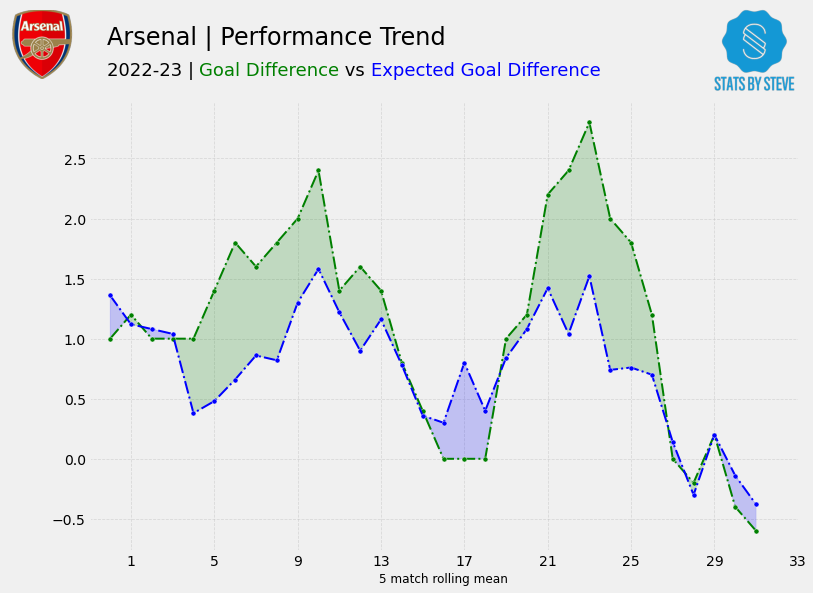

In [ ]:
generate_xg_analysis_chart(league_results)

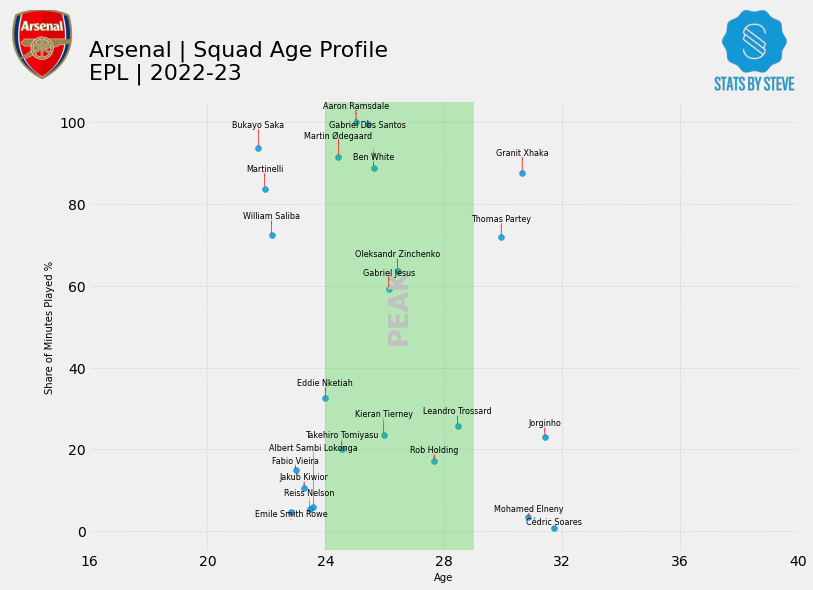

In [ ]:
squad_age_profile_chart(squad_stats_per_team,team_name)

In [ ]:
# xG conceded and xG created


league_results['cumulative_conc'] = league_results['goals_against'].cumsum()
league_results['cumulative_goals'] = league_results['goals_for'].cumsum()

poss = league_results["possession"]
conc = league_results["cumulative_conc"]
gf = league_results["cumulative_goals"]


X = pd.Series(range(len(poss)))

# Compute the rolling average (min_periods is used for the partial average)
# Here we're using a 5 game rolling average
poss = poss.rolling(window = 5, min_periods = 0).mean()
conc = conc.rolling(window = 5, min_periods = 0).mean()
scored = gf.rolling(window = 5, min_periods = 0).mean()

Create Possession Chart

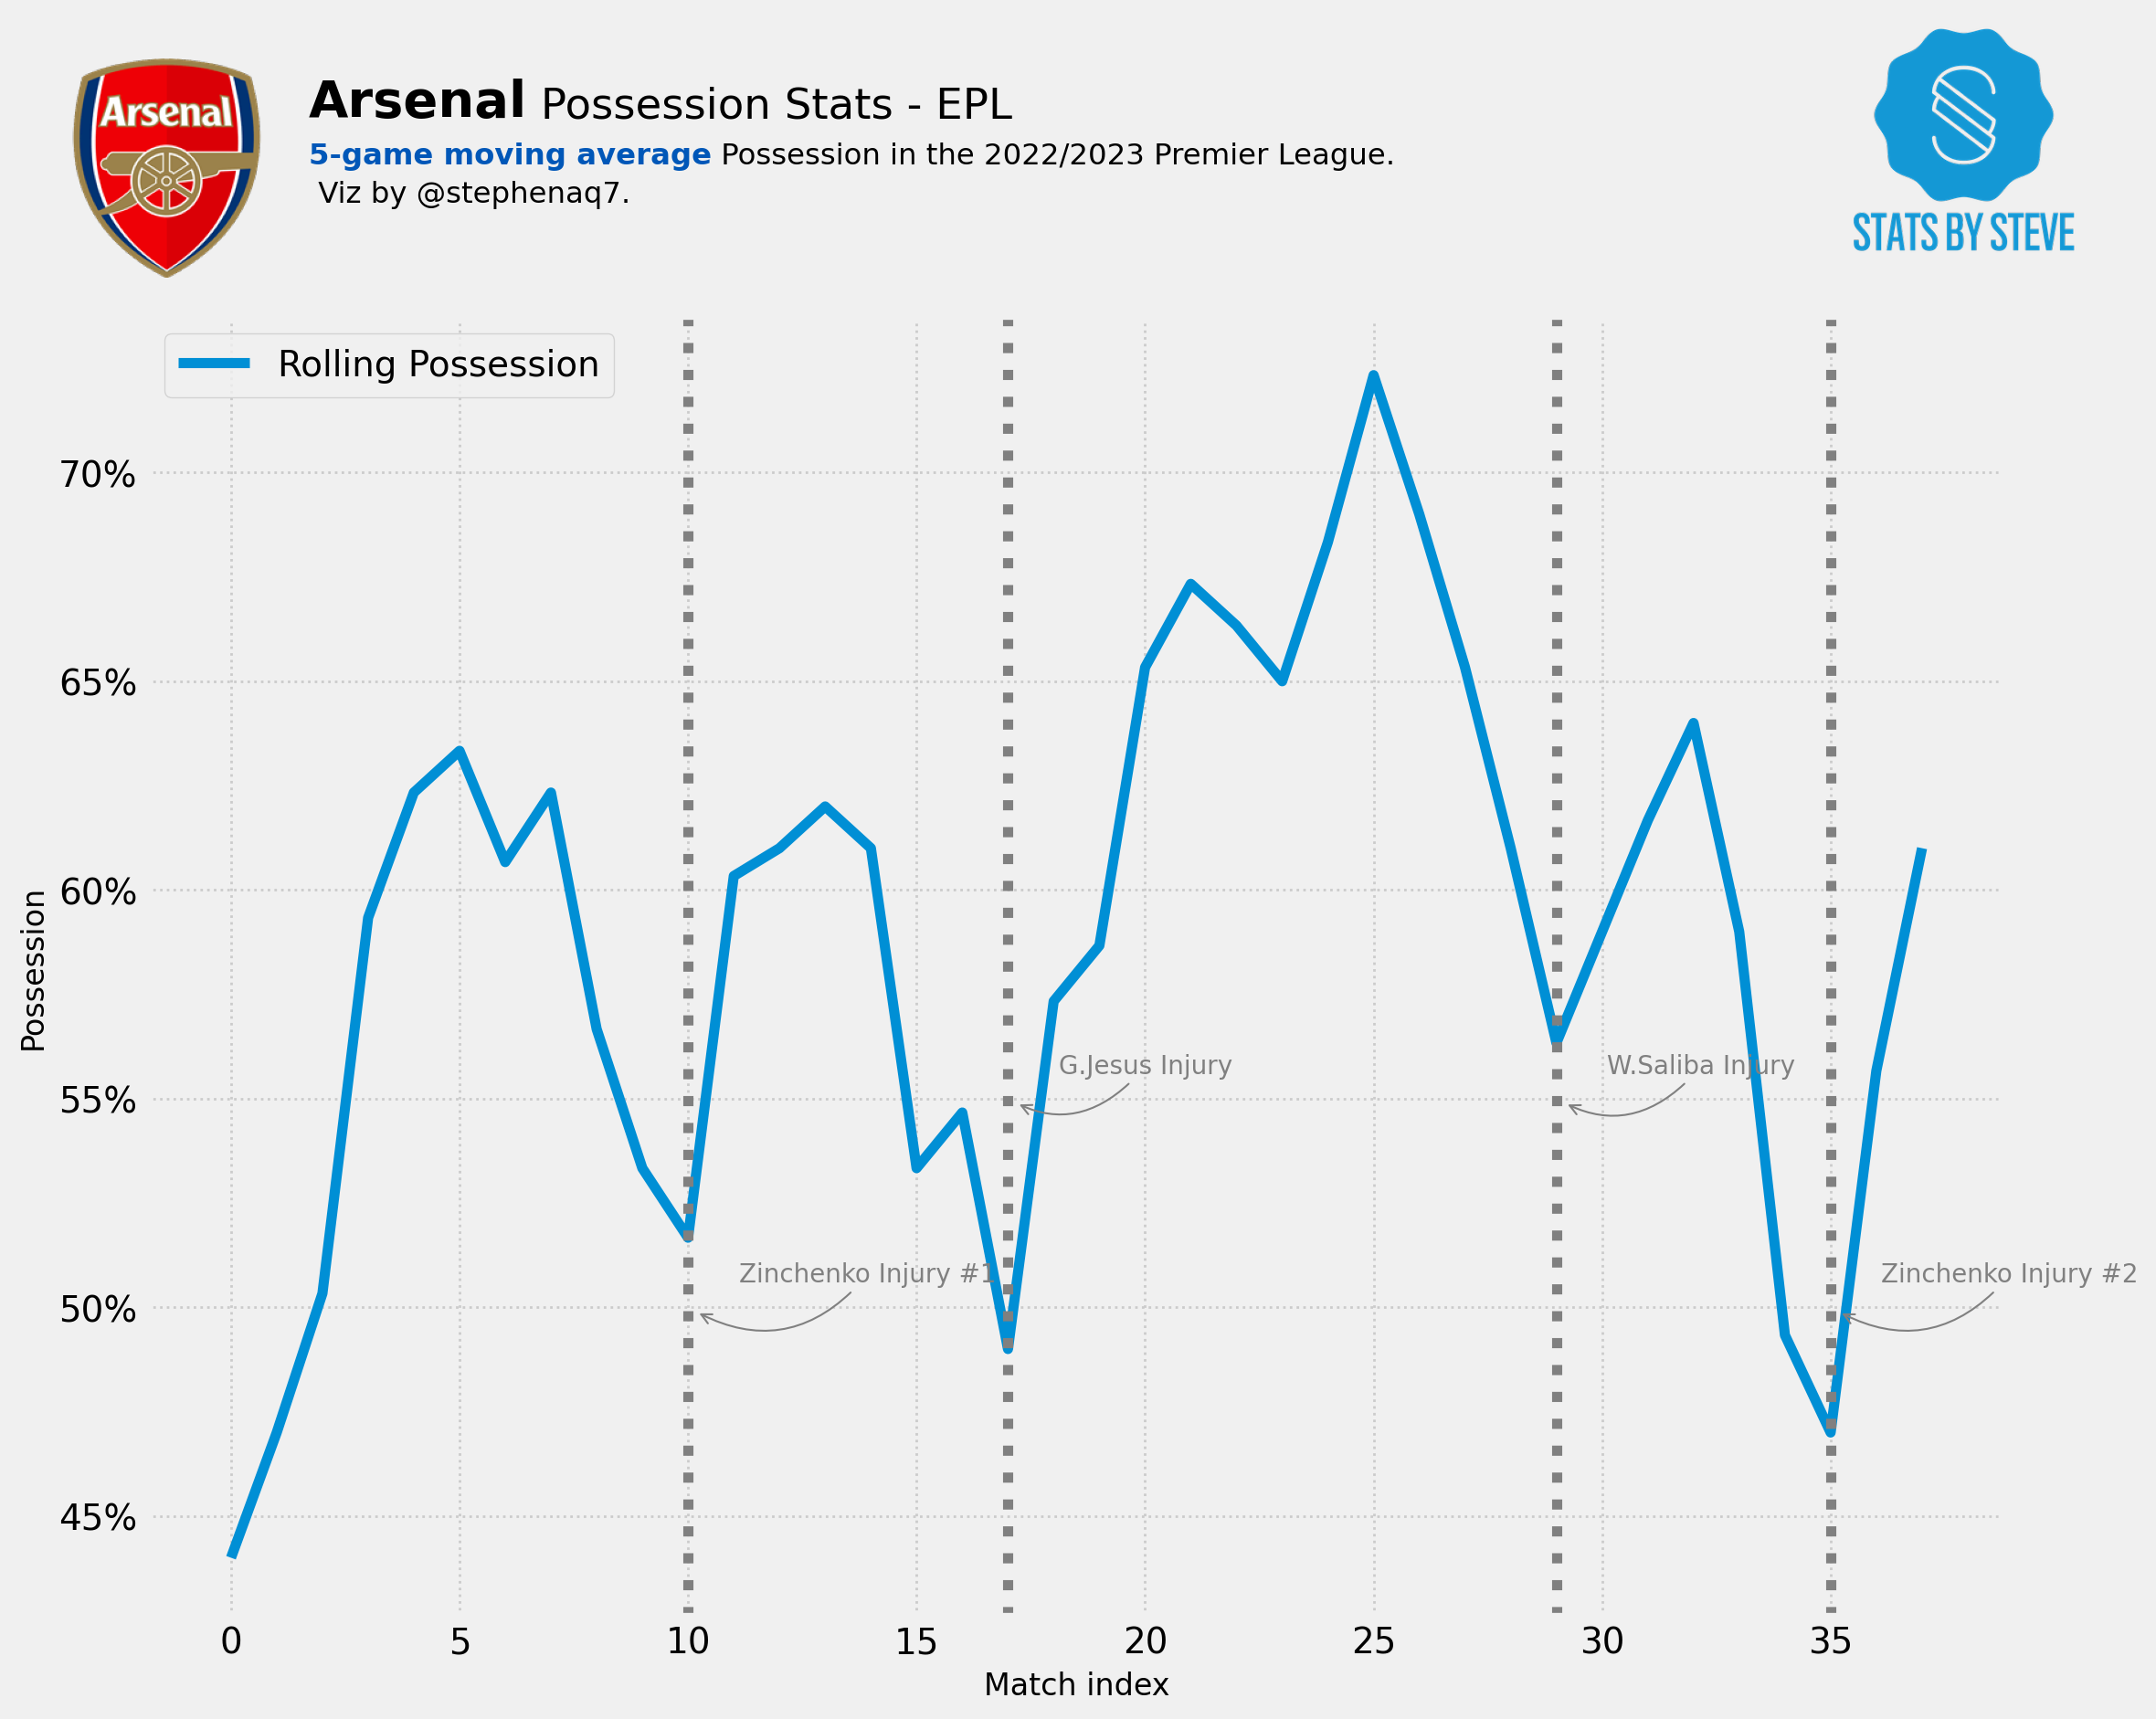

In [ ]:
import matplotlib.ticker as ticker
import numpy as np
from sklearn.linear_model import LinearRegression

# Divide the possession values by 100 to represent them as percentages
poss_percent = poss / 100

fig = plt.figure(figsize=(12, 8), dpi=200)
ax = plt.subplot(111)
style.use('fivethirtyeight')

ax.plot(X, poss_percent, label="Rolling Possession")

ax.set_xlabel("Match index", fontsize=12)
ax.set_ylabel("Possession", fontsize=12)

# Set y-axis tick labels as percentages
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

ax.legend()

ax.grid(True, linestyle='dotted')
main_color = '#0057B8'
# Adding vertical dotted lines and labels
plt.axvline(x=10, color='grey', linestyle='dotted')
plt.axvline(x=17, color='grey', linestyle='dotted')
plt.axvline(x=29, color='grey', linestyle='dotted')
plt.axvline(x=35, color='grey', linestyle='dotted')


fig_text(
    x=0.15, y=1.12, s='<Arsenal> Possession Stats - EPL', family='DM Sans',
    ha='left', va='center', weight='normal', size='large',
    highlight_textprops=[{'weight':'bold', 'size':'x-large'}]
)
fig_text(
    x=0.15, y=1.07, s='<5-game moving average> Possession in the 2022/2023 Premier League.\n Viz by @stephenaq7.',
    family='Karla',
    ha='left', va='center', size='small',
    highlight_textprops=[{'weight':'bold', 'color':main_color}]
)
ax.annotate(
    xy = (10, .50),
    xytext = (20, 10),
    textcoords = "offset points",
    text = "Zinchenko Injury #1",
    size = 10,
    color = "grey",
    arrowprops=dict(
        arrowstyle="->", shrinkA=0, shrinkB=5, color="grey", linewidth=0.75,
        connectionstyle="angle3,angleA=50,angleB=-30"
    ) # Arrow to connect annotation
)

ax.annotate(
    xy = (17, .55),
    xytext = (20, 10),
    textcoords = "offset points",
    text = "G.Jesus Injury",
    size = 10,
    color = "grey",
    arrowprops=dict(
        arrowstyle="->", shrinkA=0, shrinkB=5, color="grey", linewidth=0.75,
        connectionstyle="angle3,angleA=50,angleB=-30"
    ) # Arrow to connect annotation
)


ax.annotate(
    xy = (29, .55),
    xytext = (20, 10),
    textcoords = "offset points",
    text = "W.Saliba Injury",
    size = 10,
    color = "grey",
    arrowprops=dict(
        arrowstyle="->", shrinkA=0, shrinkB=5, color="grey", linewidth=0.75,
        connectionstyle="angle3,angleA=50,angleB=-30"
    ) # Arrow to connect annotation
)
ax_size = 0.15
image_ax = fig.add_axes(
    [0.01, 1.0, ax_size, ax_size],
    fc='None'
)


ax.annotate(
    xy = (35, .50),
    xytext = (20, 10),
    textcoords = "offset points",
    text = "Zinchenko Injury #2",
    size = 10,
    color = "grey",
    arrowprops=dict(
        arrowstyle="->", shrinkA=0, shrinkB=5, color="grey", linewidth=0.75,
        connectionstyle="angle3,angleA=50,angleB=-30"
    ) # Arrow to connect annotation
)
fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}9825.png"))
image_ax.imshow(club_icon)
image_ax.axis('off')

ax3 = fig.add_axes([0.85, 0.22, 0.11, 1.75])
ax3.axis('off')
img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/outputs/logo_transparent_background.png')
ax3.imshow(img)

plt.tight_layout()  # Adjust spacing between subplots

plt.show()




Create Goals Scored Chart

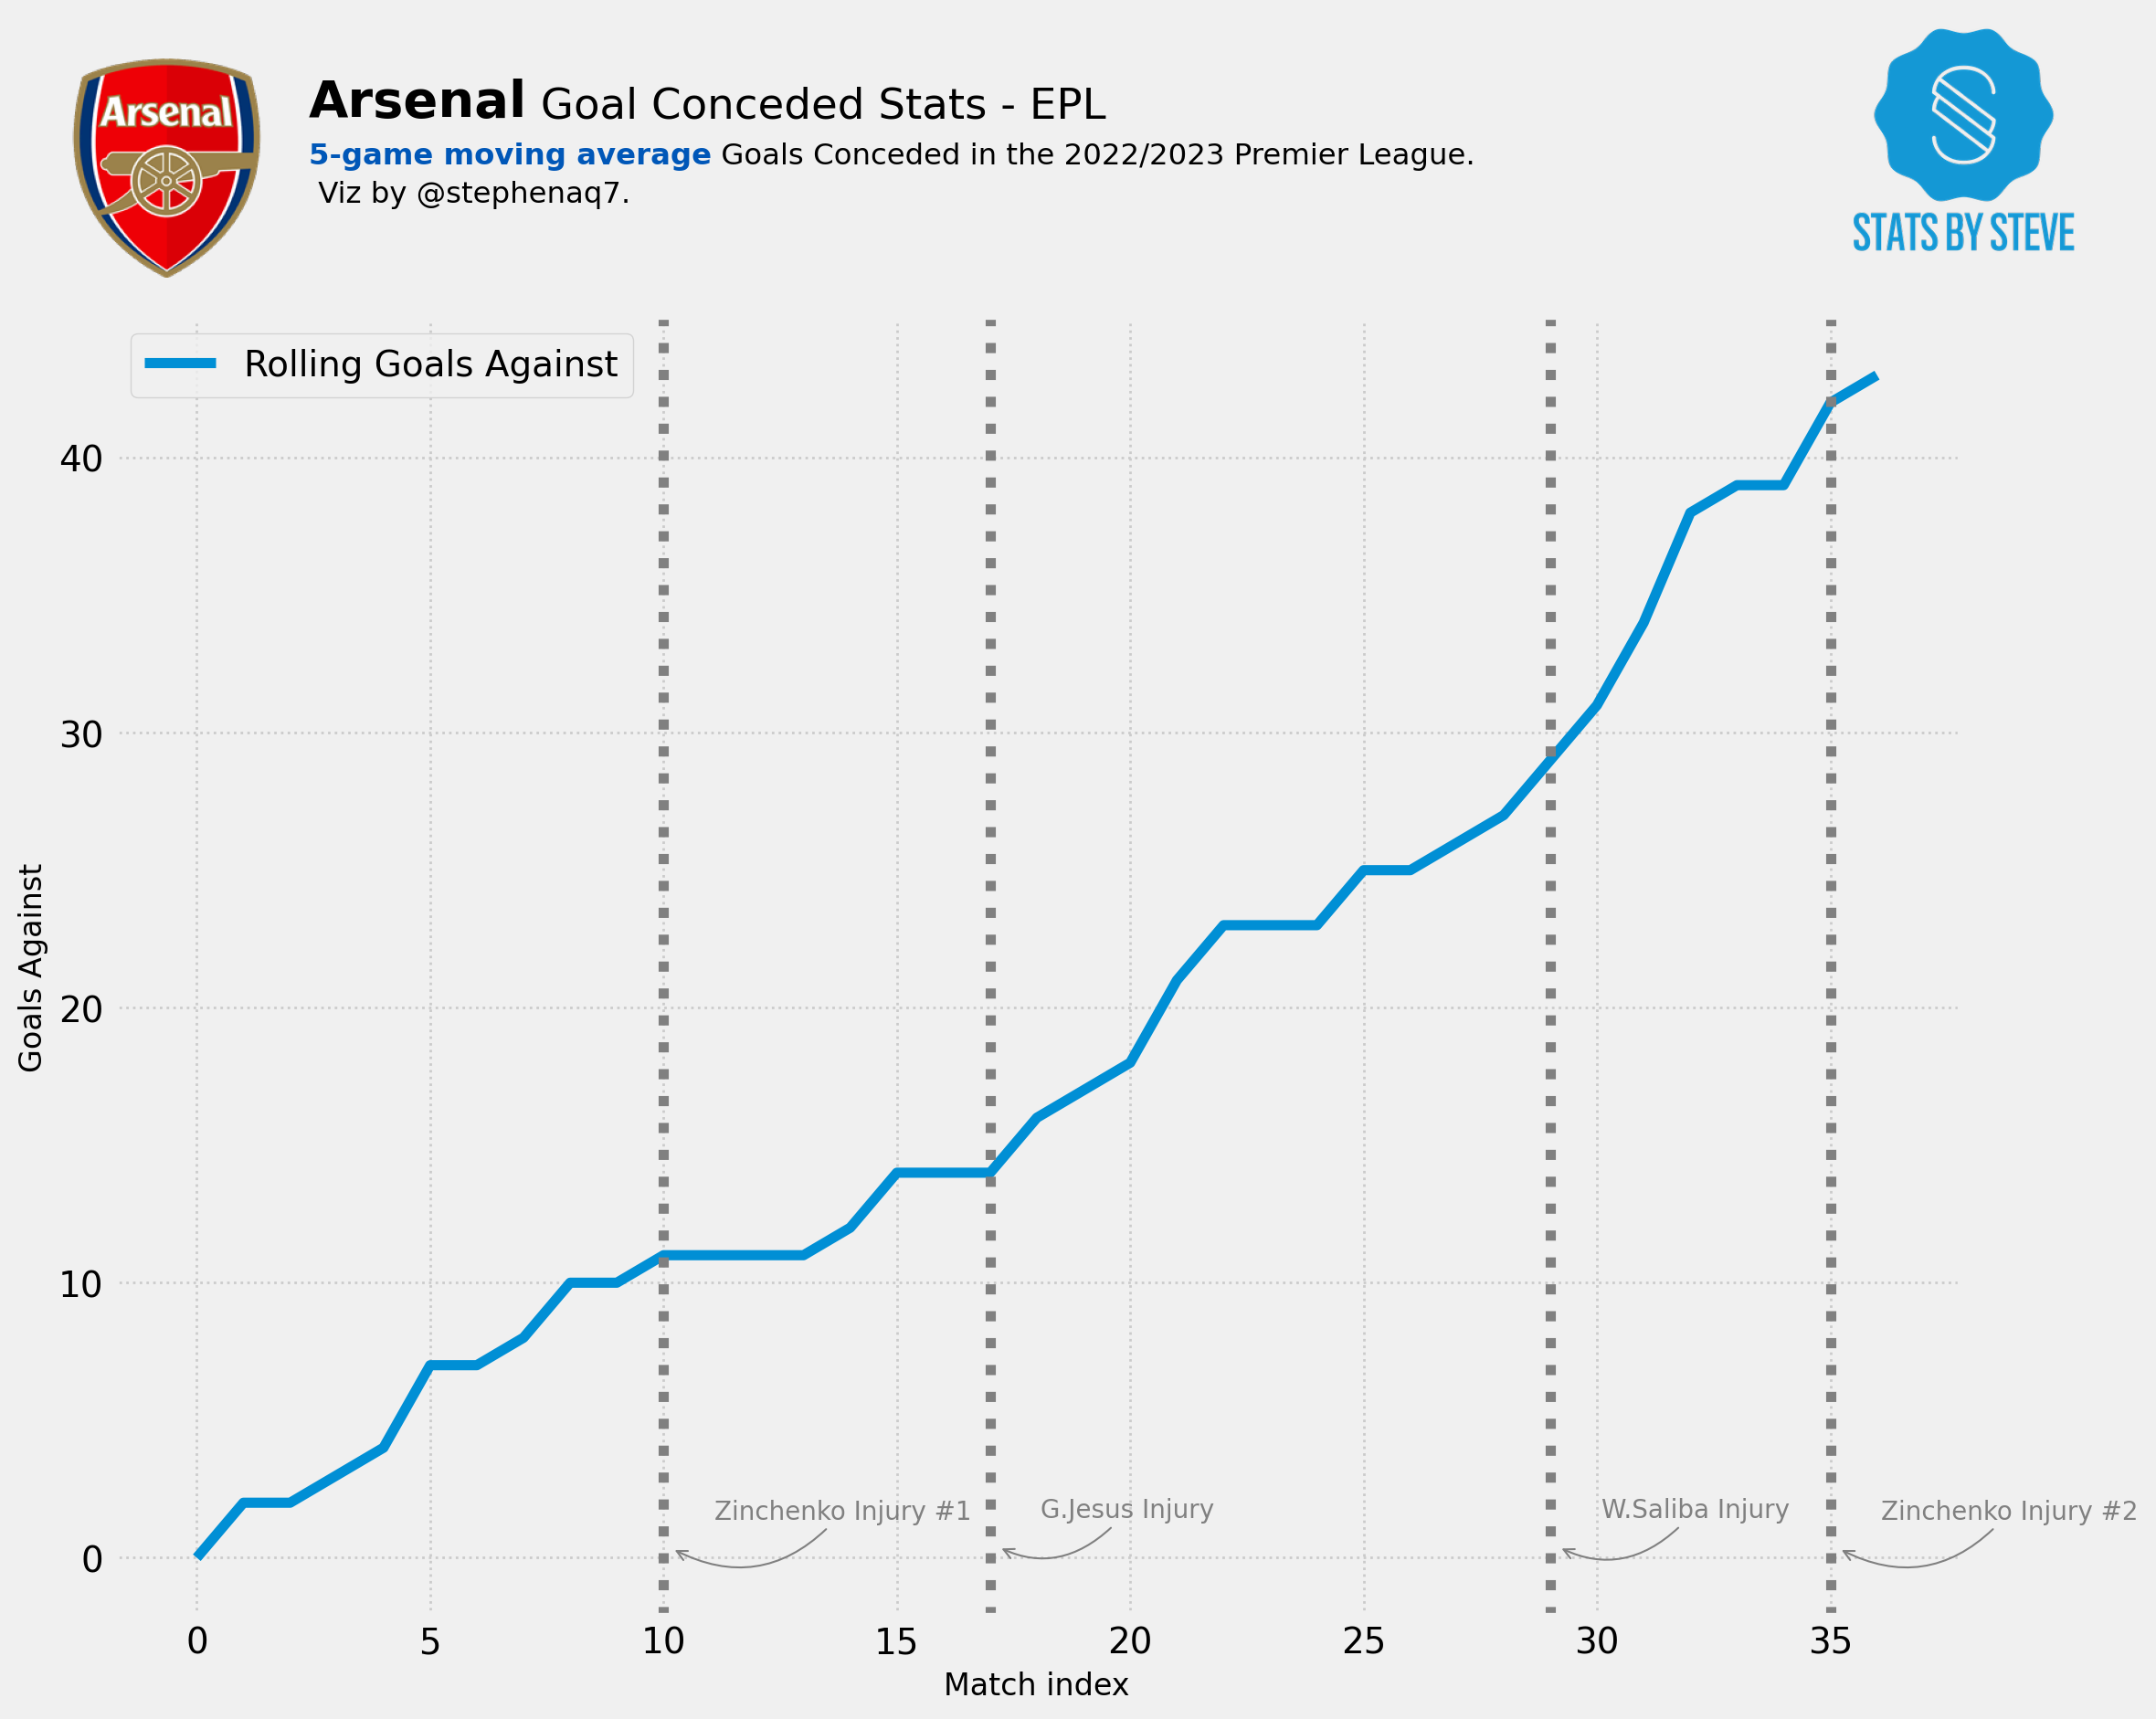

In [ ]:
import matplotlib.ticker as ticker
import numpy as np
from sklearn.linear_model import LinearRegression


fig = plt.figure(figsize=(12, 8), dpi=200)
ax = plt.subplot(111)
style.use('fivethirtyeight')

ax.plot(X, conc, label="Rolling Goals Agains")

ax.set_xlabel("Match index", fontsize=12)
ax.set_ylabel("Goals Against", fontsize=12)

# Set y-axis tick labels as percentages
# ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

ax.legend()

ax.grid(True, linestyle='dotted')
main_color = '#0057B8'
# Adding vertical dotted lines and labels
plt.axvline(x=10, color='grey', linestyle='dotted')
plt.axvline(x=17, color='grey', linestyle='dotted')
plt.axvline(x=29, color='grey', linestyle='dotted')
plt.axvline(x=35, color='grey', linestyle='dotted')


fig_text(
    x=0.15, y=1.12, s='<Arsenal> Goal Conceded Stats - EPL', family='DM Sans',
    ha='left', va='center', weight='normal', size='large',
    highlight_textprops=[{'weight':'bold', 'size':'x-large'}]
)
fig_text(
    x=0.15, y=1.07, s='<5-game moving average> Goals Conceded in the 2022/2023 Premier League.\n Viz by @stephenaq7.',
    family='Karla',
    ha='left', va='center', size='small',
    highlight_textprops=[{'weight':'bold', 'color':main_color}]
)
ax.annotate(
    xy = (10, .50),
    xytext = (20, 10),
    textcoords = "offset points",
    text = "Zinchenko Injury #1",
    size = 10,
    color = "grey",
    arrowprops=dict(
        arrowstyle="->", shrinkA=0, shrinkB=5, color="grey", linewidth=0.75,
        connectionstyle="angle3,angleA=50,angleB=-30"
    ) # Arrow to connect annotation
)

ax.annotate(
    xy = (17, .55),
    xytext = (20, 10),
    textcoords = "offset points",
    text = "G.Jesus Injury",
    size = 10,
    color = "grey",
    arrowprops=dict(
        arrowstyle="->", shrinkA=0, shrinkB=5, color="grey", linewidth=0.75,
        connectionstyle="angle3,angleA=50,angleB=-30"
    ) # Arrow to connect annotation
)


ax.annotate(
    xy = (29, .55),
    xytext = (20, 10),
    textcoords = "offset points",
    text = "W.Saliba Injury",
    size = 10,
    color = "grey",
    arrowprops=dict(
        arrowstyle="->", shrinkA=0, shrinkB=5, color="grey", linewidth=0.75,
        connectionstyle="angle3,angleA=50,angleB=-30"
    ) # Arrow to connect annotation
)
ax_size = 0.15
image_ax = fig.add_axes(
    [0.01, 1.0, ax_size, ax_size],
    fc='None'
)


ax.annotate(
    xy = (35, .50),
    xytext = (20, 10),
    textcoords = "offset points",
    text = "Zinchenko Injury #2",
    size = 10,
    color = "grey",
    arrowprops=dict(
        arrowstyle="->", shrinkA=0, shrinkB=5, color="grey", linewidth=0.75,
        connectionstyle="angle3,angleA=50,angleB=-30"
    ) # Arrow to connect annotation
)
fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}9825.png"))
image_ax.imshow(club_icon)
image_ax.axis('off')

ax3 = fig.add_axes([0.85, 0.22, 0.11, 1.75])
ax3.axis('off')
img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/outputs/logo_transparent_background.png')
ax3.imshow(img)

plt.tight_layout()  # Adjust spacing between subplots

plt.show()


Create Goals Scored Chart

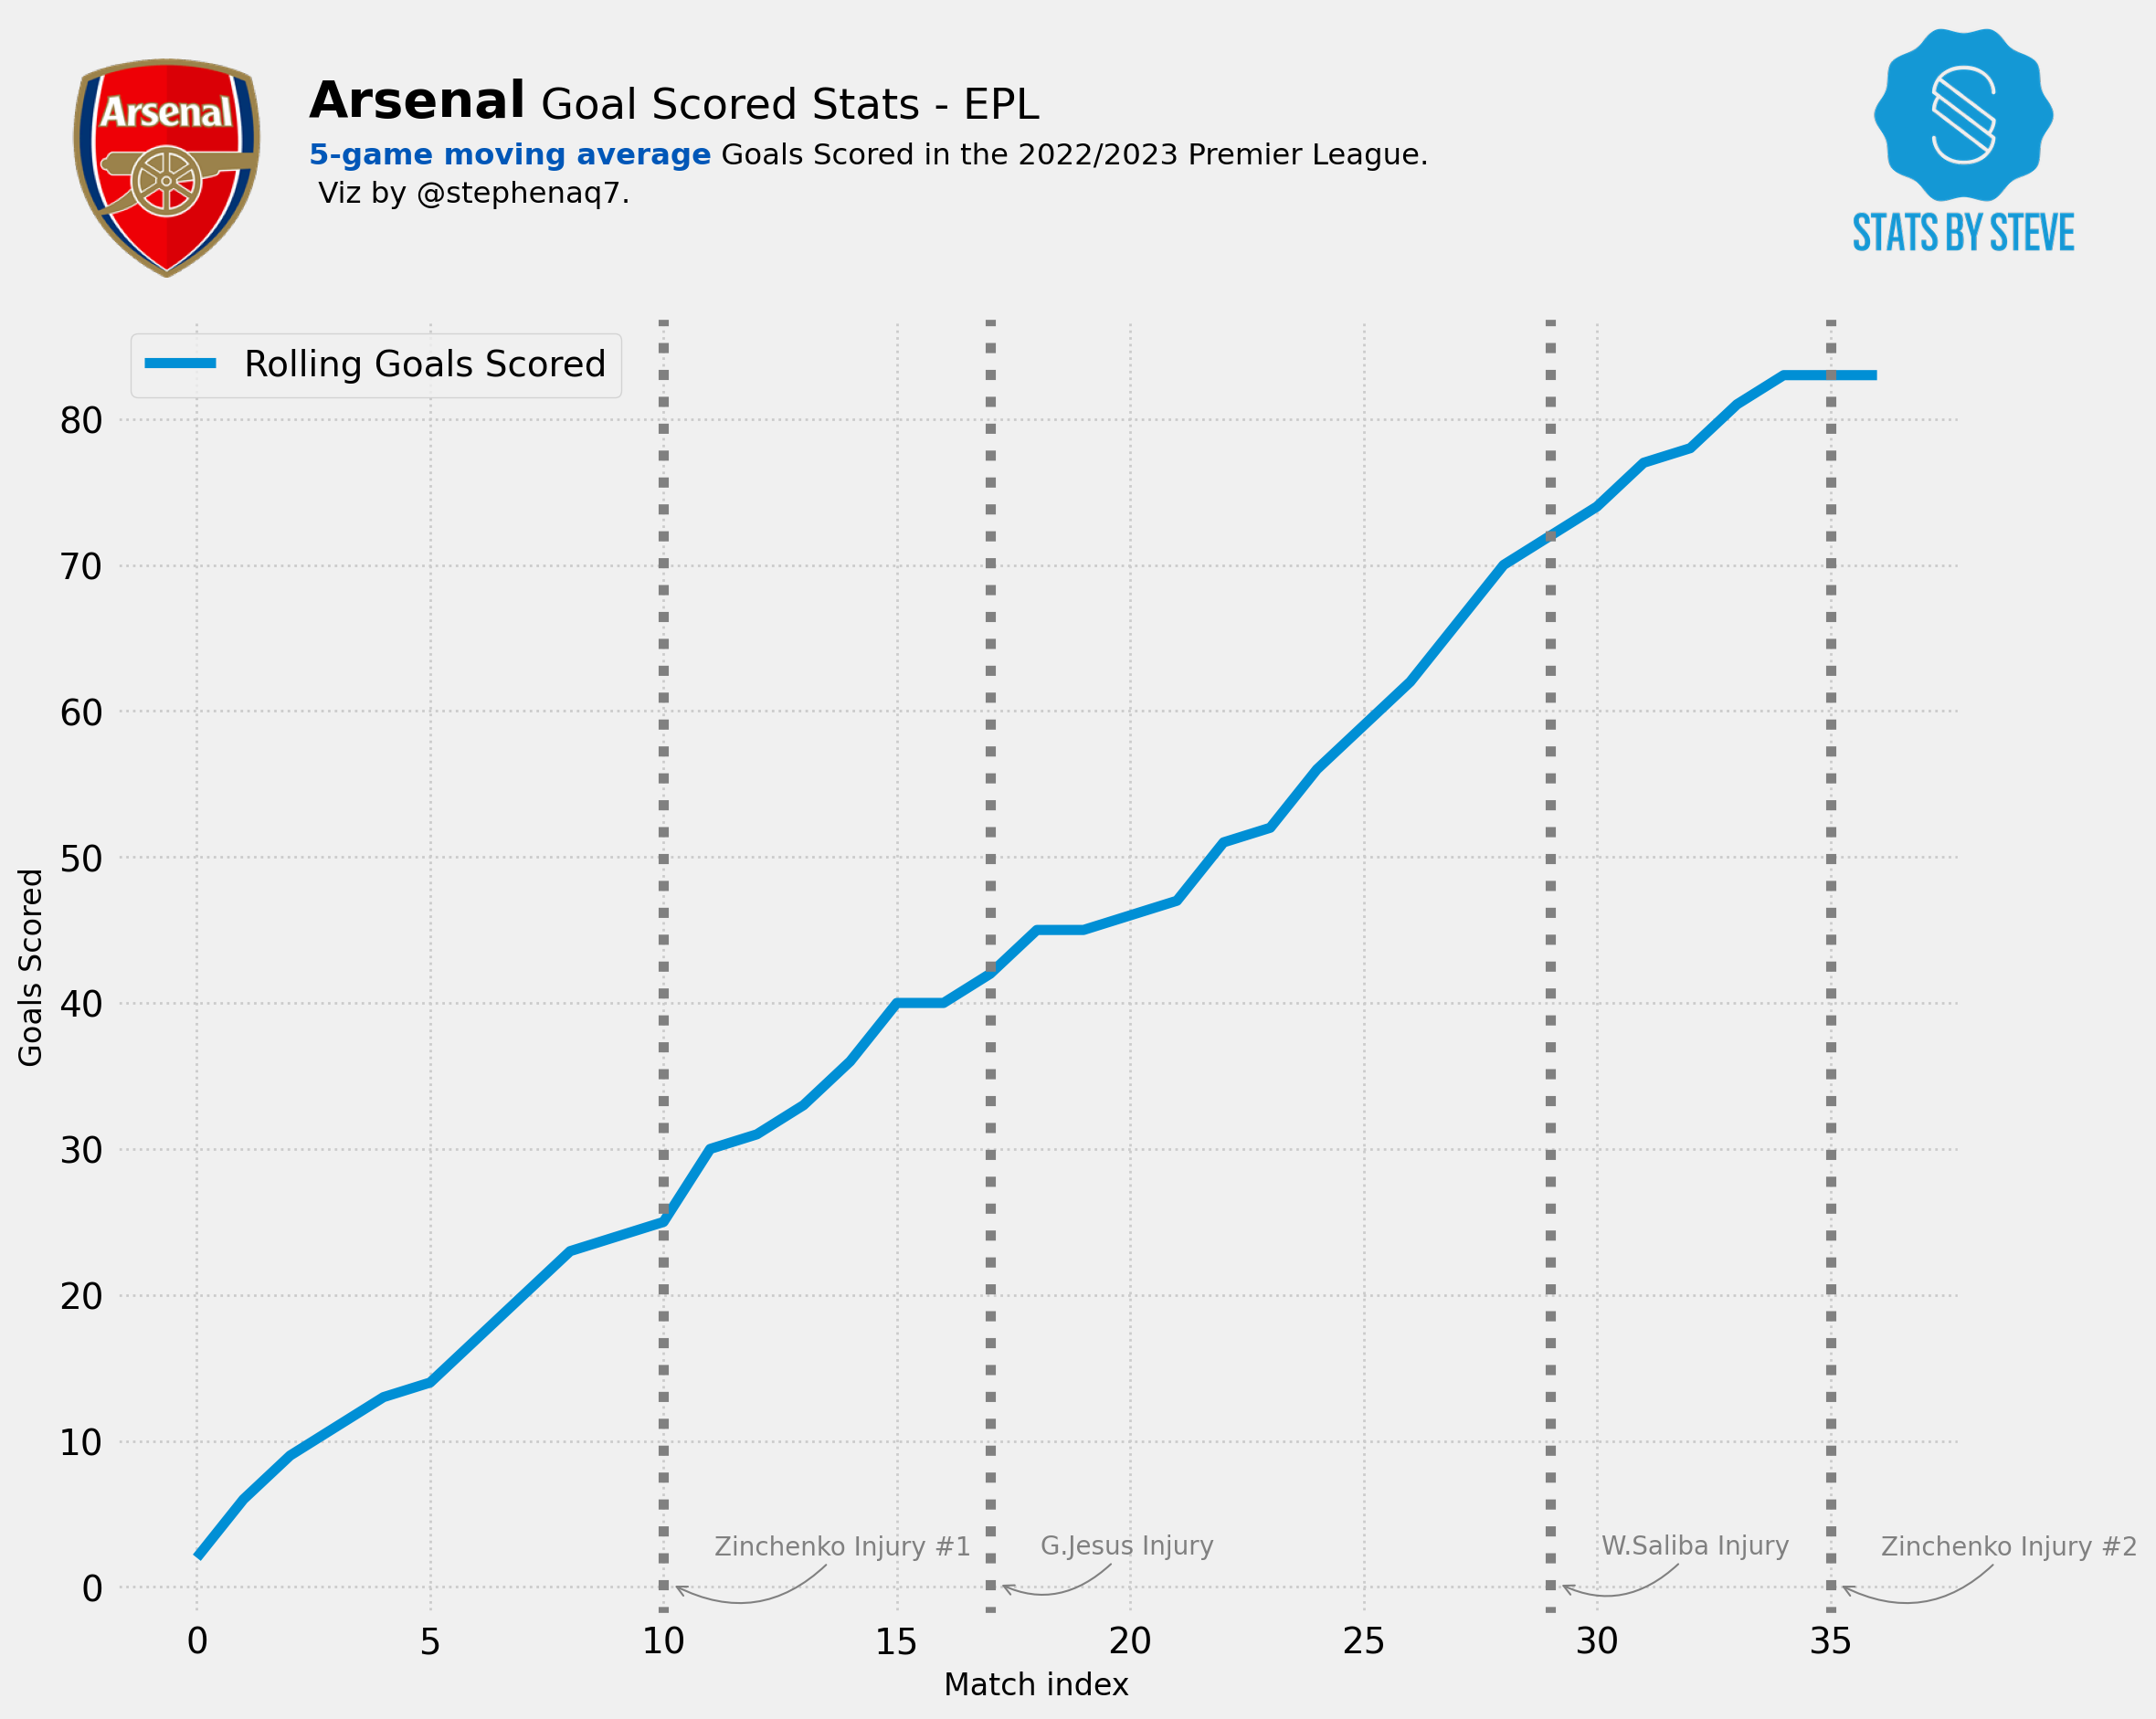

In [ ]:
import matplotlib.ticker as ticker
import numpy as np
from sklearn.linear_model import LinearRegression


fig = plt.figure(figsize=(12, 8), dpi=200)
ax = plt.subplot(111)
style.use('fivethirtyeight')

ax.plot(X, scored, label="Rolling Goals Scored")

ax.set_xlabel("Match index", fontsize=12)
ax.set_ylabel("Goals Scored", fontsize=12)

# Set y-axis tick labels as percentages
# ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

ax.legend()

ax.grid(True, linestyle='dotted')
main_color = '#0057B8'
# Adding vertical dotted lines and labels
plt.axvline(x=10, color='grey', linestyle='dotted')
plt.axvline(x=17, color='grey', linestyle='dotted')
plt.axvline(x=29, color='grey', linestyle='dotted')
plt.axvline(x=35, color='grey', linestyle='dotted')


fig_text(
    x=0.15, y=1.12, s='<Arsenal> Goal Scored Stats - EPL', family='DM Sans',
    ha='left', va='center', weight='normal', size='large',
    highlight_textprops=[{'weight':'bold', 'size':'x-large'}]
)
fig_text(
    x=0.15, y=1.07, s='<5-game moving average> Goals Scored in the 2022/2023 Premier League.\n Viz by @stephenaq7.',
    family='Karla',
    ha='left', va='center', size='small',
    highlight_textprops=[{'weight':'bold', 'color':main_color}]
)
ax.annotate(
    xy = (10, .50),
    xytext = (20, 10),
    textcoords = "offset points",
    text = "Zinchenko Injury #1",
    size = 10,
    color = "grey",
    arrowprops=dict(
        arrowstyle="->", shrinkA=0, shrinkB=5, color="grey", linewidth=0.75,
        connectionstyle="angle3,angleA=50,angleB=-30"
    ) # Arrow to connect annotation
)

ax.annotate(
    xy = (17, .55),
    xytext = (20, 10),
    textcoords = "offset points",
    text = "G.Jesus Injury",
    size = 10,
    color = "grey",
    arrowprops=dict(
        arrowstyle="->", shrinkA=0, shrinkB=5, color="grey", linewidth=0.75,
        connectionstyle="angle3,angleA=50,angleB=-30"
    ) # Arrow to connect annotation
)


ax.annotate(
    xy = (29, .55),
    xytext = (20, 10),
    textcoords = "offset points",
    text = "W.Saliba Injury",
    size = 10,
    color = "grey",
    arrowprops=dict(
        arrowstyle="->", shrinkA=0, shrinkB=5, color="grey", linewidth=0.75,
        connectionstyle="angle3,angleA=50,angleB=-30"
    ) # Arrow to connect annotation
)
ax_size = 0.15
image_ax = fig.add_axes(
    [0.01, 1.0, ax_size, ax_size],
    fc='None'
)


ax.annotate(
    xy = (35, .50),
    xytext = (20, 10),
    textcoords = "offset points",
    text = "Zinchenko Injury #2",
    size = 10,
    color = "grey",
    arrowprops=dict(
        arrowstyle="->", shrinkA=0, shrinkB=5, color="grey", linewidth=0.75,
        connectionstyle="angle3,angleA=50,angleB=-30"
    ) # Arrow to connect annotation
)
fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}9825.png"))
image_ax.imshow(club_icon)
image_ax.axis('off')

ax3 = fig.add_axes([0.85, 0.22, 0.11, 1.75])
ax3.axis('off')
img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/outputs/logo_transparent_background.png')
ax3.imshow(img)

plt.tight_layout()  # Adjust spacing between subplots

plt.show()
